# Lipton-Tarjan implementation tests

The goal of this notebook is to ensure that the code works fast and correctly.

In [1]:
%matplotlib inline

import numpy as np
import datetime
from matplotlib import pyplot as plt
from lipton_tarjan import PlanarGraphGenerator, PlanarSeparator, SeparationClass

np.random.seed(42)

The following method validates the separation computed for the graph, i.e. it checks that parts $A$ and $B$ are not adjacent, that their size is not bigger than $\frac23 n$ and that separator $C$'s size is not bigger than $2 \sqrt{2} \sqrt{n}$.

In [2]:
def is_correct_separation(graph, separation):

    if np.any(separation == SeparationClass.UNDEFINED):
        return False

    first_part_cost = graph.vertex_costs[separation == int(SeparationClass.FIRST_PART)].sum()
    second_part_cost = graph.vertex_costs[separation == int(SeparationClass.SECOND_PART)].sum()

    if max(first_part_cost, second_part_cost) > 2/3:
        return False

    separator_size = (separation == SeparationClass.SEPARATOR).sum()

    if separator_size > 2*np.sqrt(2)*np.sqrt(graph.size):
        return False

    for vertex, sep_class in enumerate(separation):

        if sep_class == SeparationClass.FIRST_PART or \
                sep_class == SeparationClass.SECOND_PART:

            for adjacent_vertex in graph.get_adjacent_vertices(vertex):
                if separation[adjacent_vertex] != SeparationClass.SEPARATOR and \
                        separation[adjacent_vertex] != sep_class:
                    return False

    return True

The next method accepts a range of graph sizes, the number of graphs of certain size to generate and the flag, indicating whether to use equal or random vertex costs. Then it runs a session of simulations, generating random graphs and computing separation for them.

In [3]:
def get_experimental_statistics(graph_size_log2s, sample_size, random_vertex_costs):

    all_separations_are_correct = True

    density_values = [0.4, 0.7, 1.0]

    densities = []
    execution_time_seconds = []
    max_part_costs = []
    separator_sizes = []

    for graph_size_log2 in graph_size_log2s:

        graph_size = 2**graph_size_log2

        for sample_index in range(sample_size):

            density = density_values[sample_index%len(density_values)]
            densities.append(density)

            graph = PlanarGraphGenerator.generate_random_graph(graph_size,
                    density, random_vertex_costs=random_vertex_costs)

            start_moment = datetime.datetime.now()
            separation = PlanarSeparator.mark_separation(graph)
            execution_seconds_passed = (datetime.datetime.now() - start_moment).total_seconds()

            execution_time_seconds.append(execution_seconds_passed)

            if not is_correct_separation(graph, separation):
                all_separations_are_correct = False

            first_part_cost = graph.vertex_costs[separation == \
                    SeparationClass.FIRST_PART].sum()
            second_part_cost = graph.vertex_costs[separation == \
                    SeparationClass.SECOND_PART].sum()
            max_part_cost = max(first_part_cost, second_part_cost)

            separator_size = (separation == SeparationClass.SEPARATOR).sum()

            max_part_costs.append(max_part_cost)
            separator_sizes.append(separator_size)
            
        print('done with size {}'.format(graph_size))

    return all_separations_are_correct, np.array(densities), \
            np.array(execution_time_seconds), np.array(max_part_costs), \
            np.array(separator_sizes)

This is a helper-method, illustrating computed results.

In [4]:
def draw_plots(graph_size_log2s, sample_size, densities, execution_time_seconds,
               max_part_costs, separator_sizes, random_vertex_costs):

    point_graph_size_log2s = np.repeat(graph_size_log2s, sample_size)

    costs = 'uniform'
    if random_vertex_costs:
        costs = 'random'

    density_values = np.unique(densities)
        
    plt.figure(figsize=(8, 18))

    plt.subplot(3, 1, 1)

    plt.plot(point_graph_size_log2s, point_graph_size_log2s - 7, label='linear tan')
    
    for density in density_values:

        density_mask = (densities == density)
        plt.scatter(point_graph_size_log2s[density_mask],
                np.log(execution_time_seconds[density_mask]), c='r', s=10, alpha=density,
                label='density={:.2f}'.format(density))

    plt.legend()
    plt.title('Runtime(graph size), {} costs'.format(costs))
    plt.xlabel('log2(graph size)')
    plt.ylabel('log(sec.)')

    plt.subplot(3, 1, 2)

    plt.plot(point_graph_size_log2s, [2/3]*len(point_graph_size_log2s),
            label='Upper bound (2/3)')
    plt.scatter(point_graph_size_log2s, max_part_costs, s=10, c='r',
            label='experimental points')
    plt.legend()
    plt.title('Max part cost(graph size), {} costs'.format(costs))
    plt.xlabel('log2(graph size)')
    plt.ylabel('Max part cost')

    plt.subplot(3, 1, 3)

    plt.plot(point_graph_size_log2s, 2*np.sqrt(2)*np.sqrt(2**point_graph_size_log2s),
            label='Upper bound')
    plt.scatter(point_graph_size_log2s, separator_sizes, s=10, c='r',
            label='experimental points')
    plt.legend()
    plt.title('Separator size(graph size), {} costs'.format(costs))
    plt.xlabel('log2(graph size)')
    plt.ylabel('Separator size')

    plt.show()

Now let's run simulations and draw plots for uniform vertex cost assingment. Scatter plots indicate simulation results, while solid lines show theoretical bounds.

1) The first plot illustrates time complexity of the algorithm in logarithmic axes. Solid line shows linear time complexity. It is clear from the plot that our implementation has linear complexity.

2) The second plot illustrates maximum cost among $A$ and $B$ parts. It is always lower than $\frac23$ threshold.

3) The final plot shows separator size depending on the graph size. Experimental points are always lower than theoretical upper bound.

done with size 8
done with size 16
done with size 32
done with size 64
done with size 128
done with size 256
done with size 512
done with size 1024
All separations are correct - True


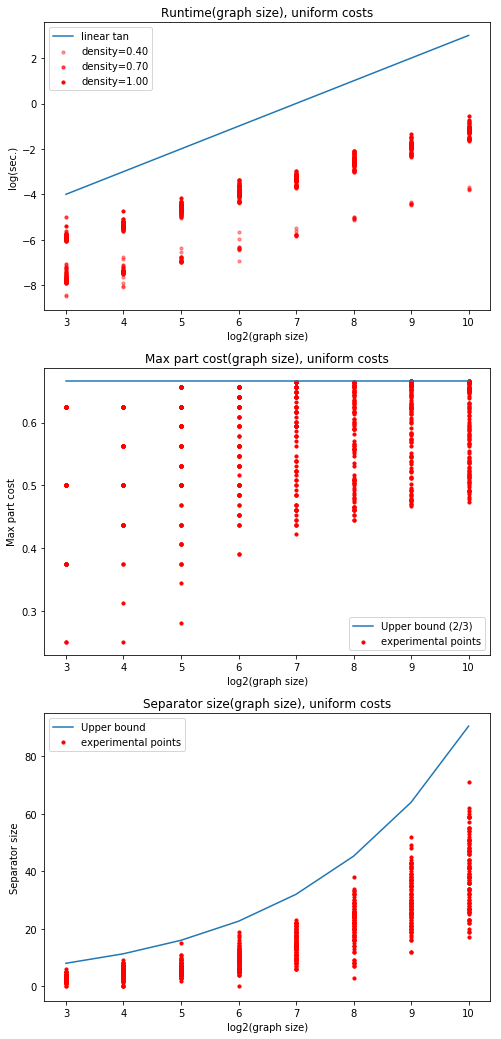

In [5]:
graph_size_log2s = np.arange(3, 11)
sample_size = 100

all_separations_are_correct, densities, execution_time_seconds, max_part_costs, \
        separator_sizes = get_experimental_statistics(graph_size_log2s, sample_size, False)

print('All separations are correct - {}'.format(all_separations_are_correct))

draw_plots(graph_size_log2s, sample_size, densities, execution_time_seconds, max_part_costs,
        separator_sizes, False)

Analogous set of simulations but for random vertex costs assignments this time. Again, algorithm results in completely valid separations and works as fast as introduced.

done with size 8
done with size 16
done with size 32
done with size 64
done with size 128
done with size 256
done with size 512
done with size 1024
All separations are correct - True


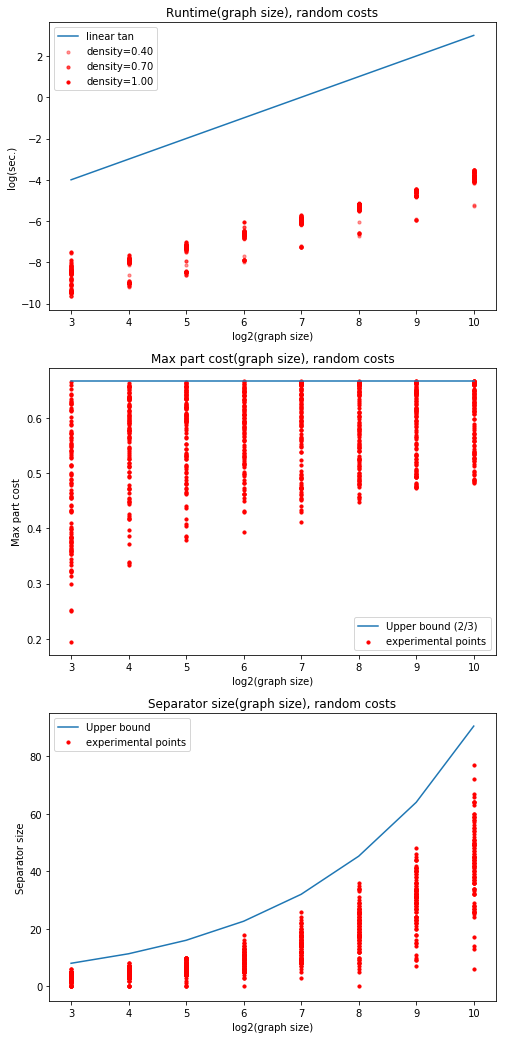

In [6]:
all_separations_are_correct, densities, execution_time_seconds, max_part_costs, \
        separator_sizes = get_experimental_statistics(graph_size_log2s, sample_size, True)

print('All separations are correct - {}'.format(all_separations_are_correct))

draw_plots(graph_size_log2s, sample_size, densities, execution_time_seconds, max_part_costs,
        separator_sizes, True)